In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
import gc
import operator


from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Bidirectional,BatchNormalization
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/data/Kaggle'

Mounted at /content/drive


In [3]:
# Packages
import os

import pandas as pd
import numpy as np
import random
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

!pip install -q kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = 'seokyunkang'
os.environ['KAGGLE_KEY'] = 'adcc3ebc524822dff2c1ba232ea45d01'

In [4]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions download -c nlp-getting-started
!mv nlp-getting-started.zip drive/MyDrive/data/Kaggle/

     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=cdf72b181094297ebc9493bebb89fd786d4e6995c91b70ed81312b62b70a3e0c
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 93.8MB/s]


In [5]:
!unzip drive/MyDrive/data/Kaggle/nlp-getting-started.zip

Archive:  drive/MyDrive/data/Kaggle/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [6]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')

In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
print(train[train["target"] == 0]["text"].values[1])
print(train[train["target"] == 1]["text"].values[1])

I love fruits
Forest fire near La Ronge Sask. Canada


In [10]:
print(train[train["keyword"].notnull()].iloc[0])

id                                                         48
keyword                                                ablaze
location                                           Birmingham
text        @bbcmtd Wholesale Markets ablaze http://t.co/l...
target                                                      1
Name: 31, dtype: object


In [11]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
print('There are %d rows and %d columns in train' %(train.shape[0],train.shape[1]))
print('There are %d rows and %d columns in test' %(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


In [13]:
print("Trainnig set 'positive target' count : {}".format((train['target']==1).sum()))
print("Trainnig set 'negative target' count : {}".format((train['target']==0).sum()))
print("Trainnig set 'positive target' ratio : {}%".format(round(((train['target']==1).sum()/train.shape[0])*100, 3)))
print("Trainnig set 'negative target' ratio : {}%".format(round(((train['target']==0).sum()/train.shape[0])*100, 3)))

Trainnig set 'positive target' count : 3271
Trainnig set 'negative target' count : 4342
Trainnig set 'positive target' ratio : 42.966%
Trainnig set 'negative target' ratio : 57.034%


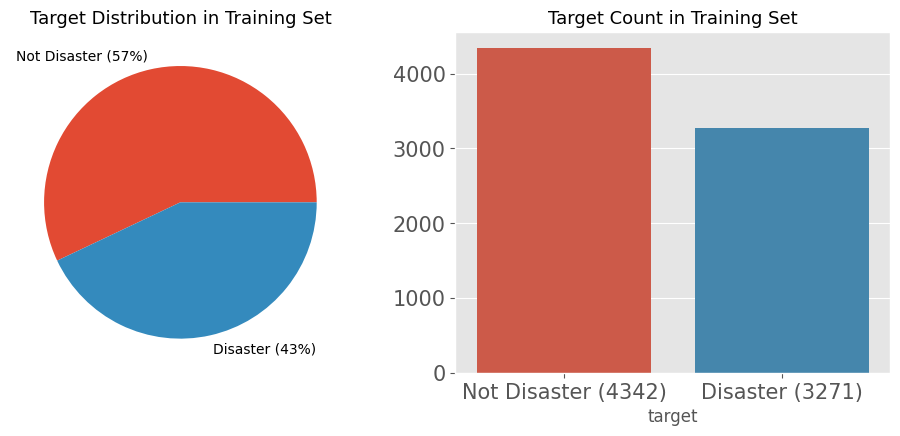

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), dpi=100)
plt.tight_layout()

train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()


Text(0, 0.5, 'samples')

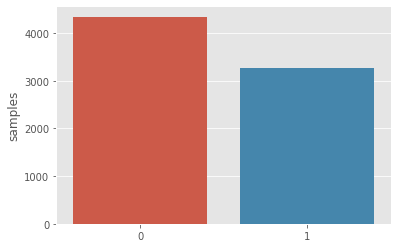

In [15]:
x = train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

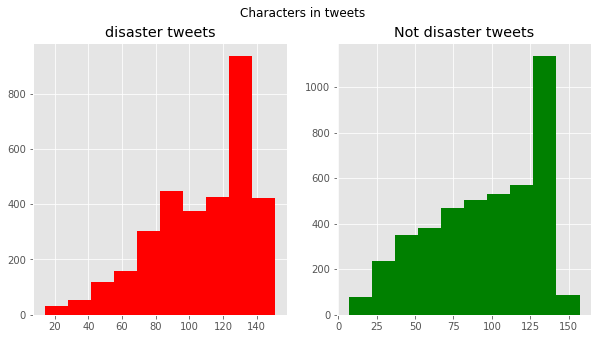

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len = train[ train['target']==1 ]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len = train[ train['target']==0 ]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

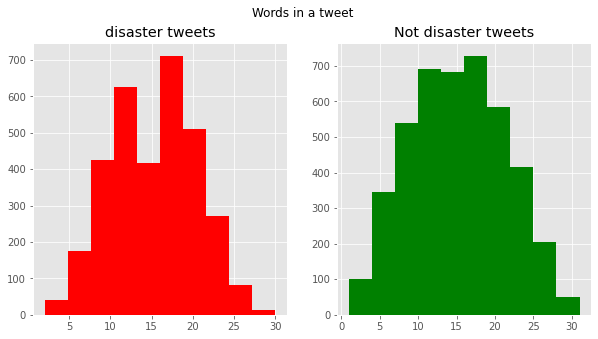

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len = train[ train['target']==1 ]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len = train[ train['target']==0 ]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

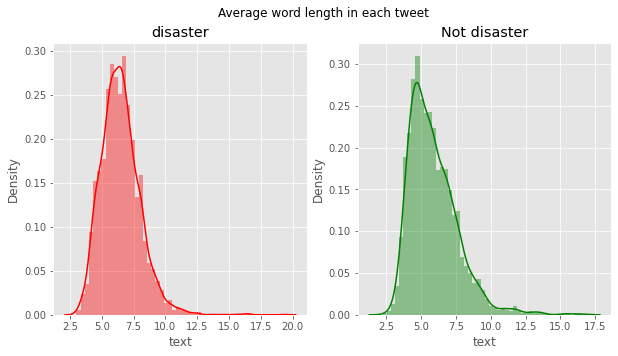

In [19]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word = train[ train['target']==1 ]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word = train[ train['target']==0 ]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

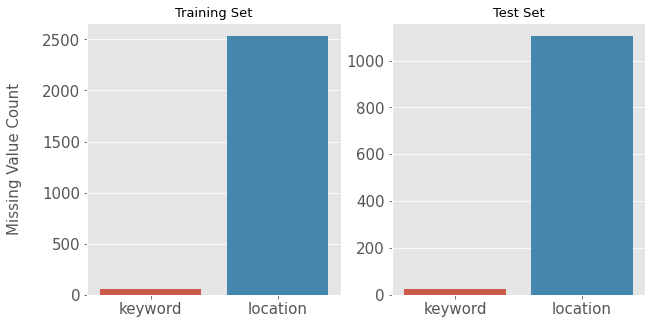

In [20]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

sns.barplot(x=train[missing_cols].isnull().sum().index, y=train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=test[missing_cols].isnull().sum().index, y=test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

In [22]:
print("Trainnig set 'keyword' missing ratio : {}%".format(round((train['keyword'].isnull().sum()/train.shape[0])*100, 3)))
print("Trainnig set 'location' missing ratio : {}%".format(round((train['location'].isnull().sum()/train.shape[0])*100, 3)))
print("Test set 'keyword' missing ratio : {}%".format(round((test['keyword'].isnull().sum()/test.shape[0])*100, 3)))
print("Test set 'location' missing ratio : {}%".format(round((test['location'].isnull().sum()/test.shape[0])*100, 3)))

Trainnig set 'keyword' missing ratio : 0.801%
Trainnig set 'location' missing ratio : 33.272%
Test set 'keyword' missing ratio : 0.797%
Test set 'location' missing ratio : 33.865%


In [23]:
for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna('Unknown')
train.head()

,id,keyword,location,text,target
0,1,Unknown,Unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,Unknown,Unknown,Forest fire near La Ronge Sask. Canada,1
2,5,Unknown,Unknown,All residents asked to 'shelter in place' are ...,1
3,6,Unknown,Unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,Unknown,Unknown,Just got sent this photo from Ruby #Alaska as ...,1


In [24]:
print(f'Number of unique values in keyword = {train["keyword"].nunique()} (Training) / {test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {train["location"].nunique()} (Training) / {test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) / 222 (Test)
Number of unique values in location = 3341 (Training) / 1603 (Test)


In [25]:
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

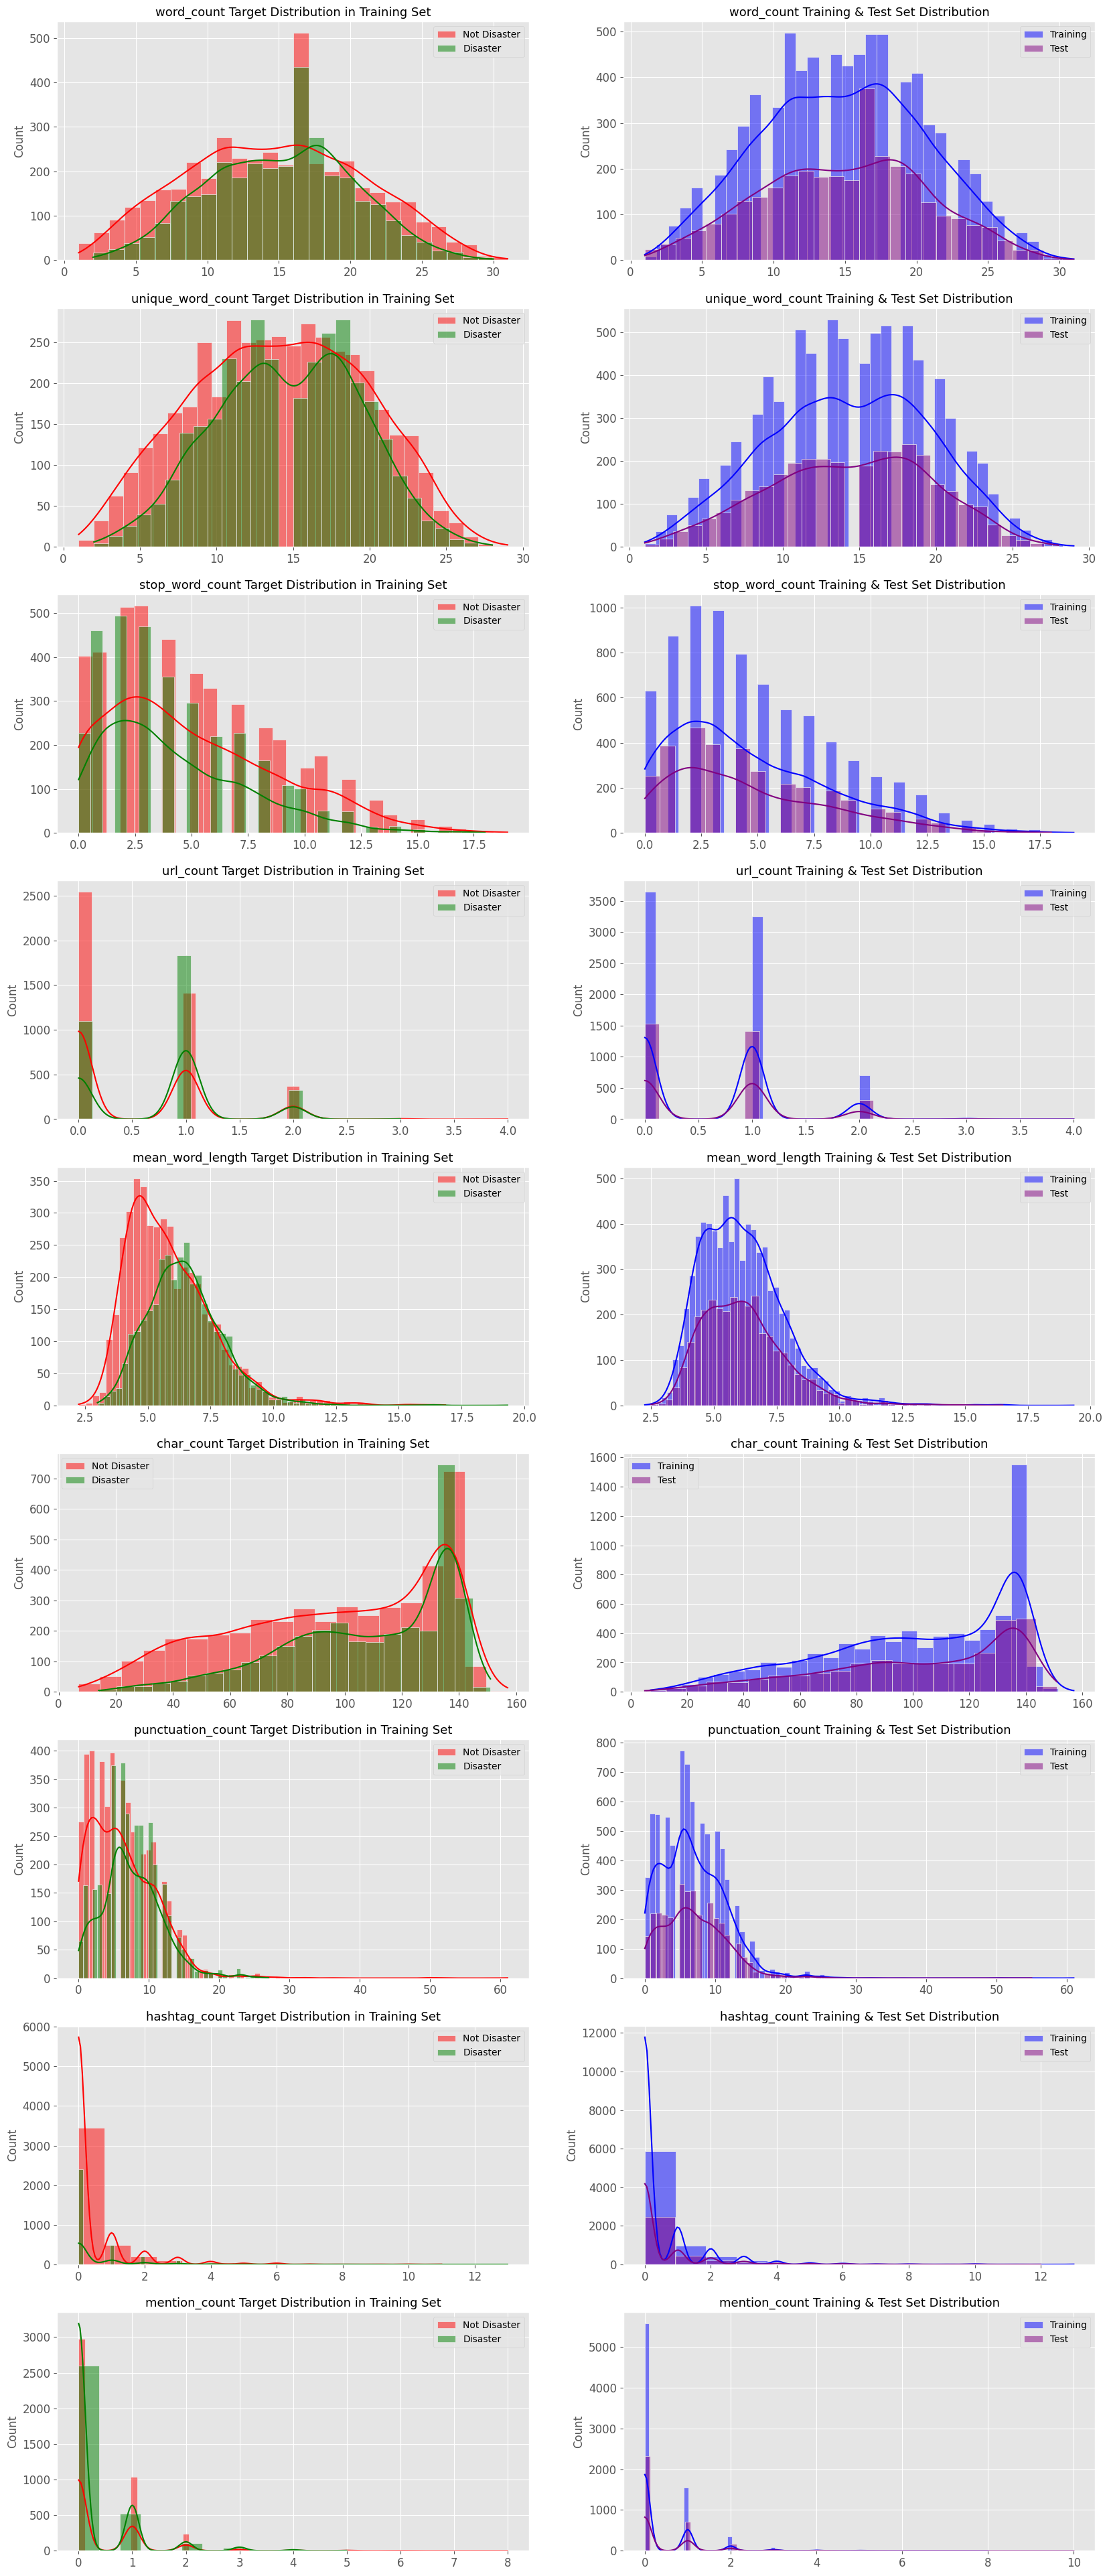

In [26]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='red', kde=True)
    sns.histplot(train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='green', kde=True)

    sns.histplot(train[feature], label='Training', ax=axes[i][1], color='blue', kde=True)
    sns.histplot(test[feature], label='Test', ax=axes[i][1], color='purple', kde=True)
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

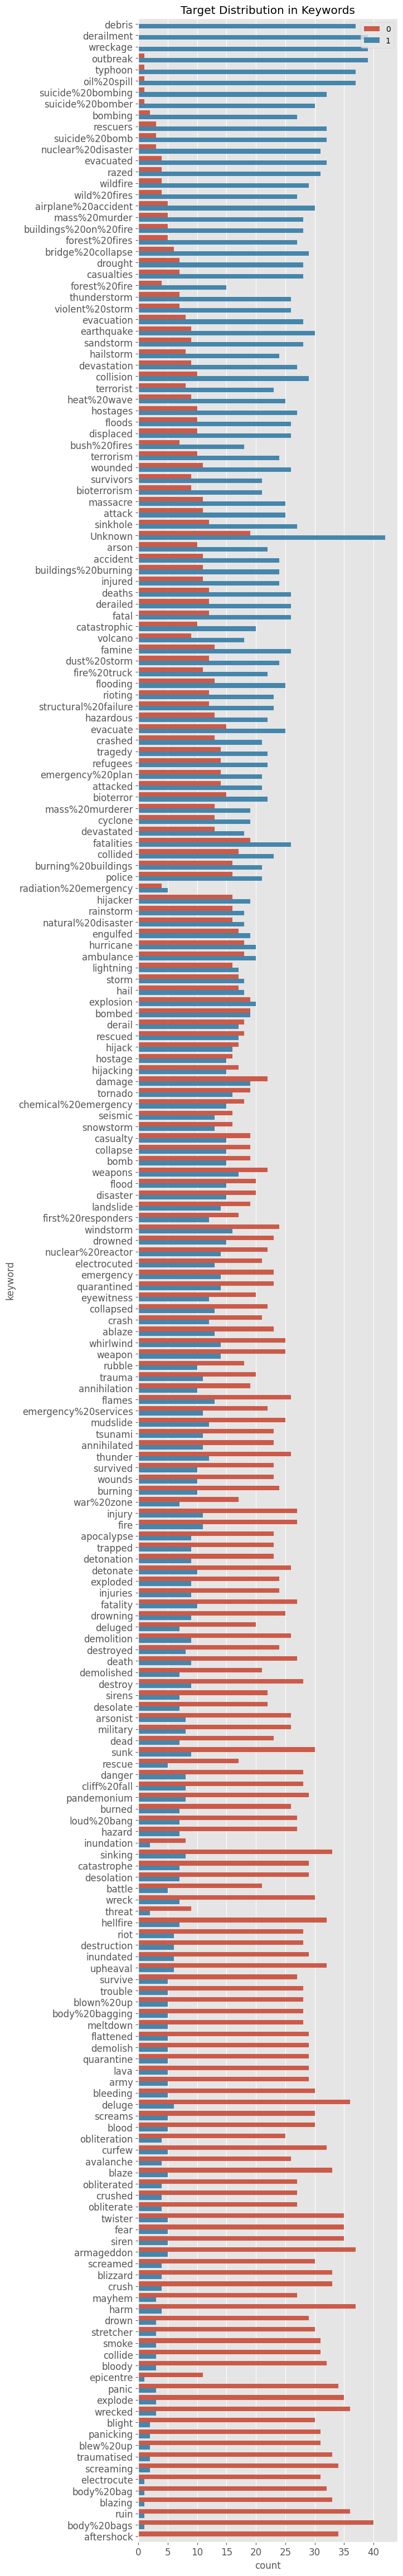

In [27]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(6, 60), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)

In [28]:
ag = train.groupby('keyword').agg({'text':np.size, 'target':np.mean}).rename(columns={'text':'Count', 'target':'Disaster Probability'})
ag.sort_values('Disaster Probability', ascending=True).head(20)

,Count,Disaster Probability
keyword,,
aftershock,34,0.000000
body%20bags,41,0.024390
ruin,37,0.027027
blazing,34,0.029412
body%20bag,33,0.030303
electrocute,32,0.031250
screaming,36,0.055556
traumatised,35,0.057143
panicking,33,0.060606


In [29]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 20

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

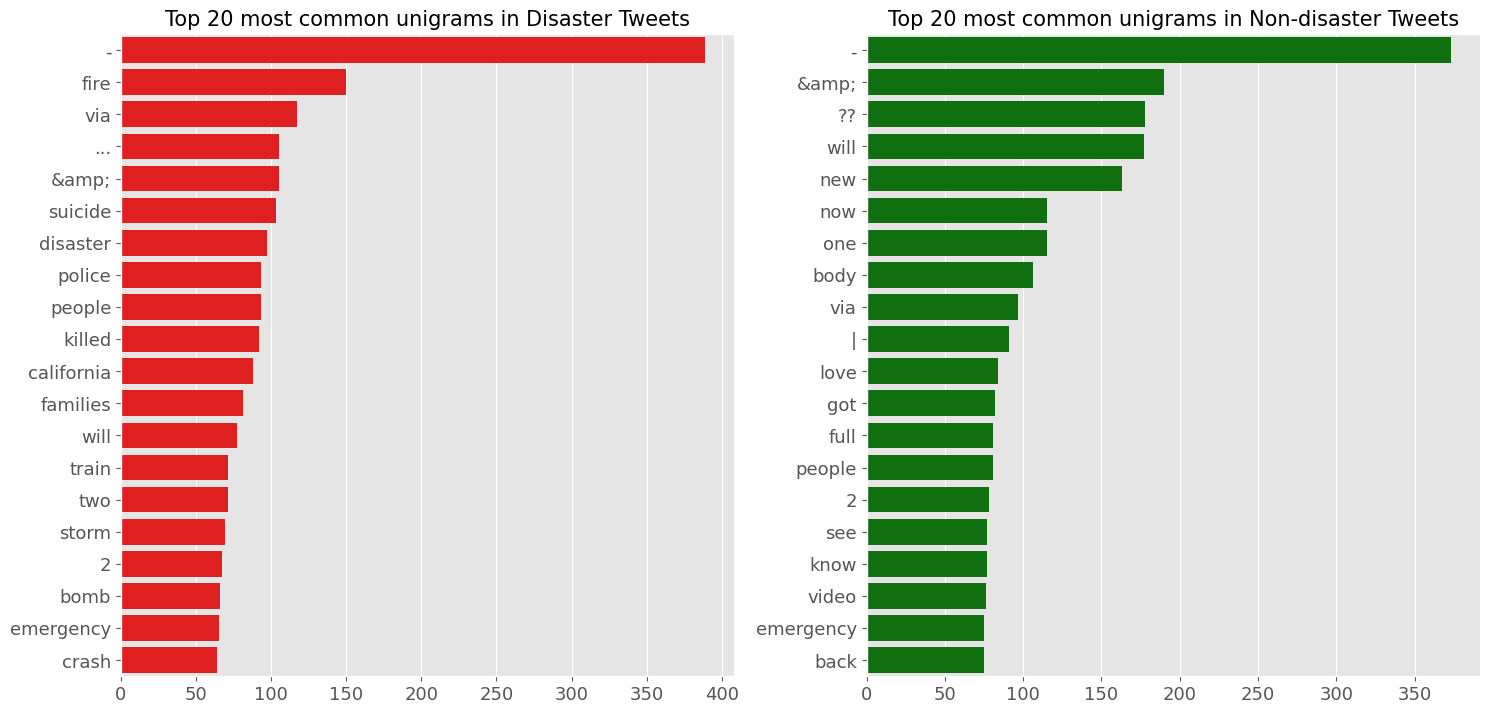

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 7), dpi=100)

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)
    
plt.tight_layout()

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

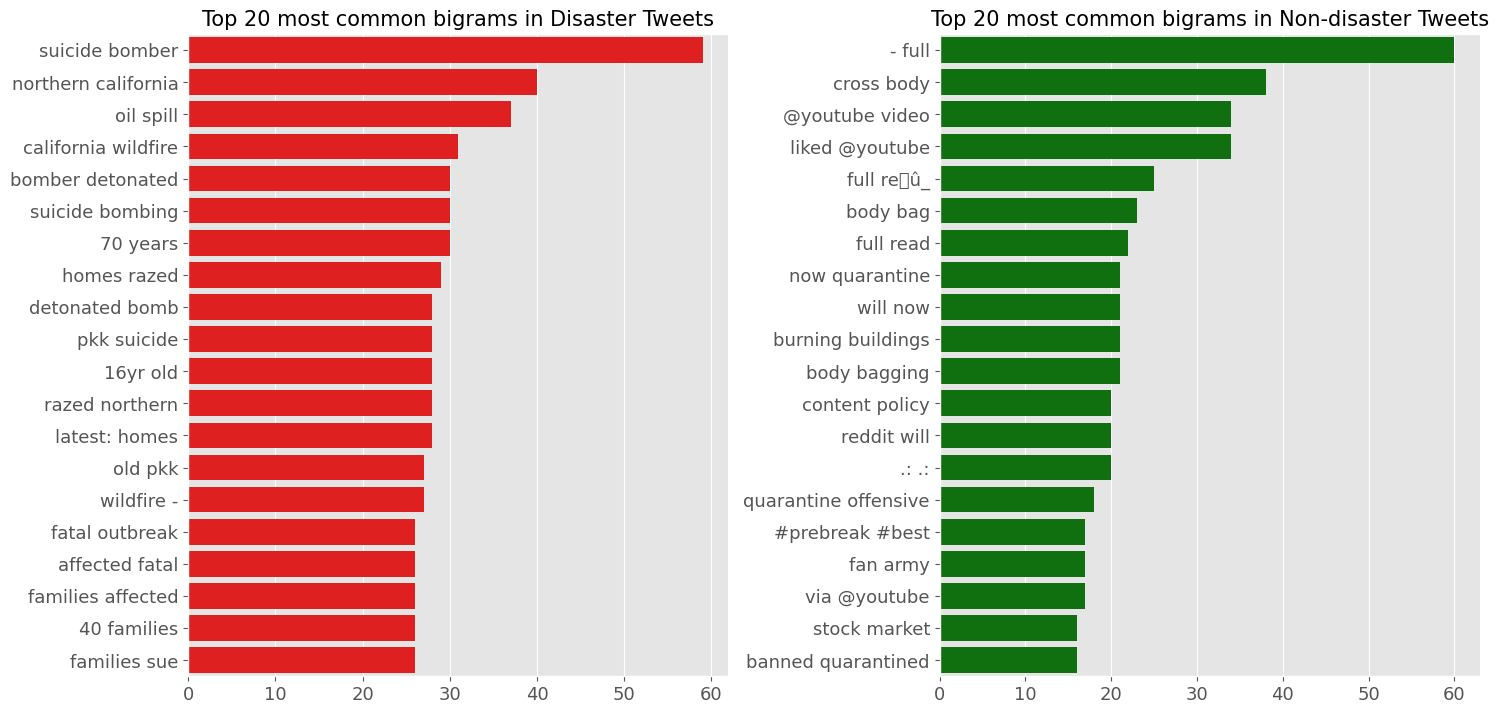

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 7), dpi=100)

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

plt.tight_layout()

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

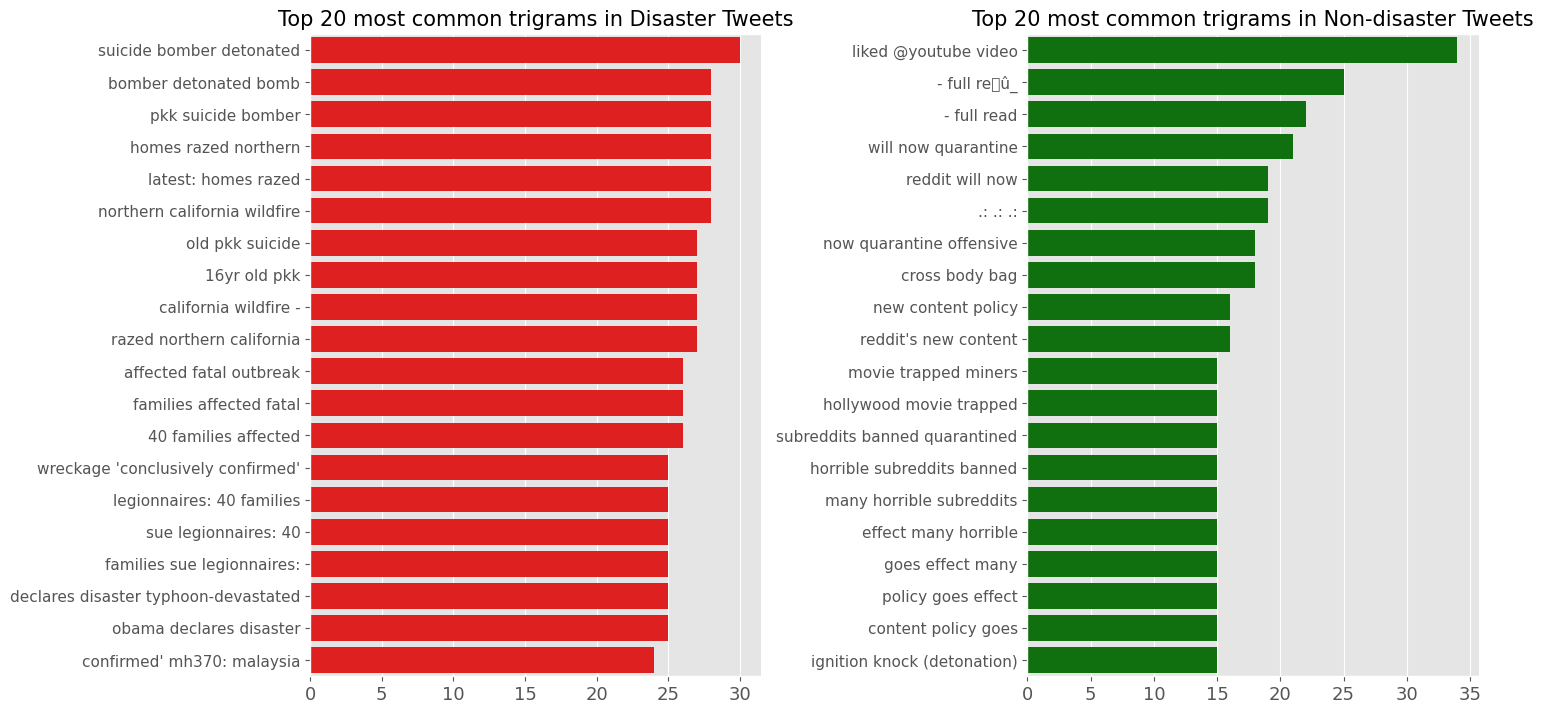

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 7), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

plt.tight_layout()

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

In [33]:
from tqdm import tqdm   # 반복문 진행률 표시 라이브러리

# Function for creating corpus(말뭉치)
def create_corpus(train):
    corpus=[]
    for tweet in tqdm(train['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [34]:
corpus=create_corpus(train)


100%|██████████| 7613/7613 [00:01<00:00, 4013.87it/s]


In [35]:
# Prepare pre-trained word embedding (GloVe.42B.300d)
# Embedding vector
embedding_dict=np.load('/content/drive/MyDrive/data/Kaggle/glove.840B.300d.pkl', allow_pickle=True)

In [36]:
NUM_W = 300
MAX_LEN=50

# Tokenize the corpus using tokenizer - Sequence is the expression of Tokenization in a sentence
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

# Use padding to adjust different lengths of sequences to a single length
tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [37]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 15013


In [38]:
# Mapping pre-trained GloVe embedding vectors for all words in the word set in training data
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,NUM_W))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 15013/15013 [00:00<00:00, 357449.88it/s]


In [39]:
# Function for creating vocabulary (A set of deduplicated tokens)
def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


# Function for checking percentage of text that can be covered by pre-trained embeddings
# oov : out of vocabulary
def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(train['text'], embedding_dict)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test['text'], embedding_dict)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

GloVe Embeddings cover 52.06% of vocabulary and 82.68% of text in Training Set
GloVe Embeddings cover 57.21% of vocabulary and 81.85% of text in Test Set


In [40]:
!pip install emot

     |████████████████████████████████| 61 kB 20 kB/s 


In [41]:
from emot.emo_unicode import UNICODE_EMOJI

# Function for converting emojis into word
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text

train['text'] = train['text'].apply(lambda x: convert_emojis(x))
test['text'] = test['text'].apply(lambda x: convert_emojis(x))

In [42]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [43]:
# Function for converting abbreviations into word
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

train["text"] = train["text"].apply(lambda x: convert_abbrev_in_text(x))
test["text"] = test["text"].apply(lambda x: convert_abbrev_in_text(x))

In [44]:
# Function for cleaning signs
def clean(tweet): 

    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)

    # HTMLs
    tweet = re.sub(r"<.*?>", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
    
    return tweet

train['text_cleaned'] = train['text'].apply(lambda s : clean(s))
test['text_cleaned'] = test['text'].apply(lambda s : clean(s))

In [45]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 5.2 MB/s 


In [46]:
from spellchecker import SpellChecker

spell = SpellChecker()

# Function for correcting spellings
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
train['text']=train['text'].apply(lambda x : correct_spellings(x))
test['text']=test['text'].apply(lambda x : correct_spellings(x))

In [ ]:
train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(train['text_cleaned'], embedding_dict)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test['text_cleaned'], embedding_dict)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

In [ ]:
del embedding_dict, train_glove_oov, test_glove_oov
gc.collect()

In [ ]:
# Function for creating model
def Create_Model():
    model = Sequential()

    embedding=Embedding(num_words,NUM_W,embeddings_initializer=Constant(embedding_matrix),
                        input_length=MAX_LEN,trainable=False)
    # Embedding(vocabulary size, dimension of embedding vector, set weight, length of input sequence, )

    model.add(embedding)
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    # recurent_dropout : Percentage of dropout in circular state
    model.add(Dense(1, activation='sigmoid'))

    optimzer=Adam(learning_rate=1e-5)

    model.compile(optimizer=optimzer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = Create_Model()
model.summary()

In [ ]:
# Padding for input
train1=tweet_pad[:train.shape[0]]

In [ ]:
# Separation for cross-validation
X_train,X_test,y_train,y_test=train_test_split(train1,train['target'].values,test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

In [ ]:
checkpoint = ModelCheckpoint('model_LSTM.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 5, min_lr = 0.001)
# ReduceLROnPlateau : Improve learning rates by dynamically adjusting learning rates when learning rates do not improve

history=model.fit(X_train,y_train,batch_size=2,epochs=30,verbose=2,validation_data=(X_test,y_test),callbacks = [reduce_lr, checkpoint])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.title('Accuracy')
plt.show()

In [ ]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
corr_sub=pd.read_csv('../input/perfect/perfect_submission.csv')

In [ ]:
# Loading model
model=tf.keras.models.load_model('./model_LSTM.h5')

In [ ]:
test1=tweet_pad[:test.shape[0]]
print('Test Set Shape = {} / Size = {}'.format(test1.shape, test1.size))

In [ ]:
ts_pre=model.predict(test1)
ts_pre=np.round(ts_pre).astype(int).reshape(3263)

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':ts_pre})
sub.to_csv('submission_LSTM.csv',index=False)

print('Test Set Accuracy : {}%'.format(round((ts_pre==corr_sub['target']).sum()/len(corr_sub)*100, 3)))

sns.countplot(x=ts_pre)
plt.xlabel('class')
plt.title('Predict Target Count in Test Set')
plt.show()